# Initial Setup

In [3]:
# Import main libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Extra Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='YOUR PROJECT ID')

In [7]:
# Clear Cache
from tensorflow.keras import backend as K
K.clear_session()

In [8]:
# Memory Efficiency and Faster Training time
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [9]:
# Set seed for reproducability
seed = 2594 
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Seed set to: {seed}")

Seed set to: 2594


# Import dataset from directory

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_140k = image_dataset_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Train',
    labels = 'inferred',
    label_mode = 'binary',
    image_size = [224, 224], 
    interpolation = 'nearest',
    batch_size = 16,
    shuffle = True,
)
print(f"Training dataset imported")

Found 140002 files belonging to 2 classes.
Training dataset imported


In [11]:
valid_39k = image_dataset_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Validation',
    labels = 'inferred',
    label_mode = 'binary',
    image_size = [224, 224],
    interpolation = 'nearest',
    batch_size = 16,
    shuffle = True
)
print(f"Validation dataset imported")

Found 39428 files belonging to 2 classes.
Validation dataset imported


In [74]:
# Take 40k and 10k Initially
train = train_140k.take(40000 // 16)
valid = valid_39k.take(15000 // 16)

In [75]:
# Sample size
print(tf.data.experimental.cardinality(train))
print(tf.data.experimental.cardinality(valid))

tf.Tensor(2500, shape=(), dtype=int64)
tf.Tensor(937, shape=(), dtype=int64)


# Cache and Preprocess Dataset

In [14]:
# Convert image datatype to float32
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [15]:
# Caching for better Memory Effeciency
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (
    train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
valid = (
    valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# Import EfficientNetB0 for base

In [16]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False, # remove head since we need to use ours for DFD
    weights = 'imagenet', # pretrained weights learnt on ImageNet
    input_shape = (224,224,3) # h, w, channels
)

In [17]:
base_model.trainable = False # dont wanna fuck it up

# Declare and Define the model

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
model = keras.Sequential([
    base_model, # EffecientNetB7
    layers.GlobalAveragePooling2D(), # To reduce the input size from bazillion to countable
    
    # Block 1
    layers.Dense(units=1024, activation='relu'), # Dense layer 1
    layers.Dropout(0.3), # 20% neurons are sent to bed every forward prop
    
    # Block 2
    layers.Dense(units=512, activation='relu'), # Dense layer 1
    layers.Dropout(0.3), # 20% neurons are sent to bed every forward prop
    
    # Final output layer
    layers.Dense(units=1, activation='sigmoid')
])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [69]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [70]:
early_stopping = EarlyStopping(
    patience = 4,
    monitor='val_loss',
    restore_best_weights = True
)

In [80]:
# Fit your model
history = model.fit(
    train,
    validation_data = [valid],
    epochs = 20,
    callbacks = [early_stopping],
    verbose = 1
)
print("Model Training Completed")

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - binary_accuracy: 0.8546 - loss: 0.3274 - val_binary_accuracy: 0.8337 - val_loss: 0.3810
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - binary_accuracy: 0.8634 - loss: 0.3129 - val_binary_accuracy: 0.8286 - val_loss: 0.4229
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - binary_accuracy: 0.8700 - loss: 0.2931 - val_binary_accuracy: 0.8280 - val_loss: 0.3975
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - binary_accuracy: 0.8751 - loss: 0.2802 - val_binary_accuracy: 0.8254 - val_loss: 0.4208
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - binary_accuracy: 0.8849 - loss: 0.2700 - val_binary_accuracy: 0.8320 - val_loss: 0.4295
Model Training Completed


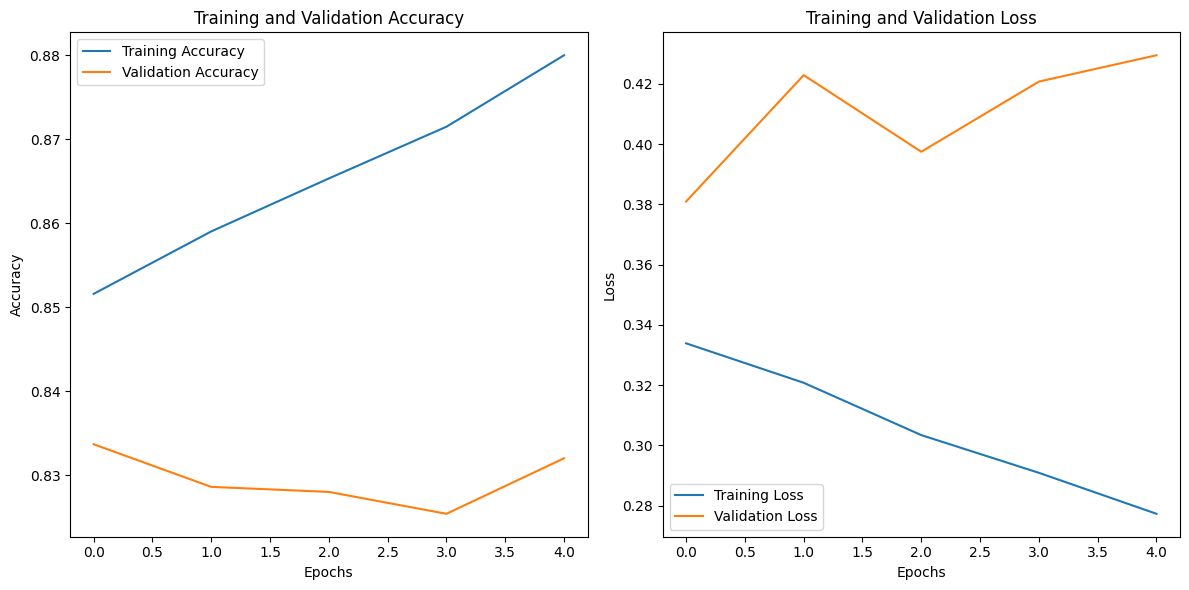

In [81]:
# Get training and validation accuracy
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create figure and axes for plotting
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [82]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,560,748 (36.47 MB)

 Trainable params: 1,837,057 (7.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 3,674,120 (14.02 MB)

In [83]:
# Save your model
model.save('/kaggle/working/dfd_ENB0_88_83.h5')